<a href="https://colab.research.google.com/github/glombardo/Research/blob/main/Understanding_Self_Control_Failures_in_Everyday_Decisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to Survey data: https://docs.google.com/spreadsheets/d/1SmHMxUkMJ9m1FaNvVjtMSxM-AGkk-ftRZkovc4zZFac/edit?resourcekey=&gid=113783496#gid=113783496

In [1]:
!pip install factor_analyzer==0.5.1  # for KMO + Bartlett tests (optional)
!pip install -q ipywidgets                       # widget manager for Colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=4025fad36543ca2e9743a718b2205f562861332dac2fb7ca4340ac579c3b076b
  Stored in directory: /root/.cache/pip/wheels/fa/f7/53/a55a8a56668a6fe0199e0e02b6e0ae3007ec35cdf6e4c25df7
Successfully built factor_analyzer
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from ipywidgets import Dropdown, VBox
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

plt.style.use("default")

In [8]:
new_df.head()

,Q3_ordinal,Q4_ordinal,Q5_ordinal,Q6_ordinal,Q7_ordinal,Q8_ordinal,Q9_ordinal,Q10_ordinal,Q11_ordinal,Q12_ordinal
0,0.727607,0.361158,-0.123613,-1.683689,-0.847469,-0.590511,-0.186817,-1.485782,0.690267,-0.256074
1,-1.374369,-2.768875,2.019010,-1.683689,-1.765561,0.339991,0.696317,1.485782,0.690267,-0.256074
2,-1.374369,-2.768875,0.947698,-1.683689,-1.765561,1.270493,-0.186817,0.495261,-0.335272,-0.256074
3,0.727607,0.361158,-0.123613,-1.683689,-0.847469,-0.590511,0.696317,-0.495261,-0.335272,-0.256074
4,0.727607,0.361158,-2.266236,-0.271563,-2.683653,-2.451515,1.579451,-2.476303,-2.386351,-1.920553


## process data - only run if you didn't upload the processed file)

In [9]:
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler

df = pd.read_excel("guidol_survey (Responses).xlsx")

def shorten_column_name(col):
    match = re.search(r'^(Q\d+)\s', str(col))
    if match:
        return match.group(1)  # e.g. "Q5"
    else:
        return col

df.rename(columns=shorten_column_name, inplace=True)

Q1_dummies = pd.get_dummies(df['Q1'], prefix='Q1')
Q2_dummies = pd.get_dummies(df['Q2'], prefix='Q2')

# Q3: Time preference
q3_map = {
    '$100 today': 0,       # More immediate bias
    '$120 in a month': 1   # More future orientation
}

# Q4: Future time preference
q4_map = {
    '$100 in 12 months': 0,
    '$120 in 13 months': 1
}

# Q5: Frequency of prioritizing immediate benefits
q5_map = {
    'Always': 5,
    'Often': 4,
    'Sometimes': 3,
    'Rarely': 2,
    'Never': 1
}

# Q6: Reaction to a stock loss (sunk-cost bias)
q6_map = {
    'Hold the stock until it returns to $50, even if better investments are available': 2,  # Highest sunk-cost bias
    'Decide based on new information unrelated to the original purchase price': 1,         # Medium
    'Sell it immediately and reinvest elsewhere': 0                                       # Lowest
}

# Q7: Reaction to a smaller raise than colleagues (social comparison)
q7_map = {
    'Very disappointed': 4,  # Highest negative reaction
    'Slightly disappointed': 3,
    'Neutral': 2,
    'Slightly happy': 1,
    'Very happy': 0          # Lowest negative reaction
}

# Q8: Extent to which past performance/experiences influence current decisions
q8_map = {
    'A great deal': 5,
    'Quite a bit': 4,
    'Somewhat': 3,
    'A little': 2,
    'Not at all': 1
}

# Q9: Accuracy of predictions about future free time
# (Not strictly “ordinal” in a traditional sense, but we can still map them.)
q9_map = {
    'I usually underestimate how busy I will be': 0,
    'I usually overestimate how busy I will be': 1,
    'My predictions are mostly accurate': 2,
    'I don’t usually think about this': 3
}

# Q10: Self-assessed likelihood of achieving goals relative to peers
q10_map = {
    'Much more likely': 4,
    'Slightly more likely': 3,
    'About the same': 2,
    'Slightly less likely': 1,
    'Much less likely': 0
}

# Q11: Confidence in future meal choices matching current preferences
q11_map = {
    'Very confident: I almost always want what I previously planned': 4,
    'Somewhat confident: I usually stick to my choices, but sometimes change my mind': 3,
    'Neutral: I get it right about half the time': 2,
    'Not very confident: I often change my mind when the time comes': 1,
    'Not at all confident: My current preferences rarely match my future cravings': 0
}

# Q12: Retrospective accuracy of past outcome predictions
q12_map = {
    'I was too optimistic': 2,
    'I was about right': 1,
    'I was too pessimistic': 0
}


df['Q3_ordinal']  = df['Q3'].map(q3_map)
df['Q4_ordinal']  = df['Q4'].map(q4_map)
df['Q5_ordinal']  = df['Q5'].map(q5_map)
df['Q6_ordinal']  = df['Q6'].map(q6_map)
df['Q7_ordinal']  = df['Q7'].map(q7_map)
df['Q8_ordinal']  = df['Q8'].map(q8_map)
df['Q9_ordinal']  = df['Q9'].map(q9_map)
df['Q10_ordinal'] = df['Q10'].map(q10_map)
df['Q11_ordinal'] = df['Q11'].map(q11_map)
df['Q12_ordinal'] = df['Q12'].map(q12_map)

new_df = pd.concat(
    [
        df['Q3_ordinal'],
        df['Q4_ordinal'],
        df['Q5_ordinal'],
        df['Q6_ordinal'],
        df['Q7_ordinal'],
        df['Q8_ordinal'],
        df['Q9_ordinal'],
        df['Q10_ordinal'],
        df['Q11_ordinal'],
        df['Q12_ordinal']
    ],
    axis=1
)

new_df.dropna(inplace=True)
new_df.replace({True: 1, False: 0}, inplace=True)

new_df.replace({True: 1, False: 0}, inplace=True)

# Scale each variable except Q1 and Q2 derived columns
scaler = StandardScaler()
# only scale columns that end in "_ordinal"
scale_cols = [col for col in new_df.columns if col.endswith('_ordinal')]
new_df[scale_cols] = scaler.fit_transform(new_df[scale_cols])

new_df

new_df.to_excel("coded_scaled_responses.xlsx", index=False)


## Generate summary statistics.

In [10]:
df = pd.read_excel('coded_scaled_responses.xlsx')

age_cols    = [c for c in df.columns if c.startswith('Q1_')]
gender_cols = [c for c in df.columns if c.startswith('Q2_')]

bias_cols   = ['Q3_ordinal','Q4_ordinal','Q5_ordinal',
               'Q6_ordinal','Q7_ordinal','Q8_ordinal',
               'Q9_ordinal','Q10_ordinal',
               'Q11_ordinal','Q12_ordinal']

In [11]:

import plotly.graph_objects as go


FIG_WIDTH  = 600
FIG_HEIGHT = 400

question_labels = {
    # Present Bias
    'Q3_ordinal' : 'Present Bias — Q3',
    'Q4_ordinal' : 'Present Bias — Q4',
    'Q5_ordinal' : 'Present Bias — Q5',
    # Reference-Dependent Utility
    'Q6_ordinal' : 'Ref-Dep Util — Q6',
    'Q7_ordinal' : 'Ref-Dep Util — Q7',
    'Q8_ordinal' : 'Ref-Dep Util — Q8',
    # Projection Bias
    'Q9_ordinal' : 'Projection Bias — Q9',
    'Q10_ordinal': 'Projection Bias — Q10',
    # Over-Optimism
    'Q11_ordinal': 'Over-Optimism — Q11',
    'Q12_ordinal': 'Over-Optimism — Q12'
}


var_labels, xs, ys = [], [], []


age_series = (df[age_cols].sum()
              .rename(lambda s: s.replace('Q1_', '')))
var_labels.append('Age (Q1)')
xs.append(age_series.index.astype(str))
ys.append(age_series.values)

gender_series = (df[gender_cols].sum()
                 .rename(lambda s: s.replace('Q2_', '')))
var_labels.append('Gender (Q2)')
xs.append(gender_series.index.astype(str))
ys.append(gender_series.values)


for col in bias_cols:
    counts = df[col].value_counts().sort_index()
    var_labels.append(question_labels[col])
    xs.append(counts.index.astype(str))
    ys.append(counts.values)


fig = go.Figure()

for i, (xvals, yvals, label) in enumerate(zip(xs, ys, var_labels)):
    fig.add_bar(
        x=xvals, y=yvals,
        name=label,
        visible=(i == 0)
    )

dropdown_buttons = [
    dict(
        label=lbl,
        method='update',
        args=[
            {'visible': [j == i for j in range(len(var_labels))]},
            {'title': f'Distribution for "{lbl}"'}
        ]
    )
    for i, lbl in enumerate(var_labels)
]

fig.update_layout(
    width=FIG_WIDTH,
    height=FIG_HEIGHT,
    title=f'Distribution for "{var_labels[0]}"',
    xaxis_title='Response category',
    yaxis_title='Count',
    updatemenus=[dict(
        active=0,
        buttons=dropdown_buttons,
        x=0.0, y=1.15, xanchor='left'
    )],
    template='plotly_white',
    showlegend=False
)

fig.show()


## Conduct PCA on the data to determine the following:

1 - Are there as many PCs as the behavioral traits initially proposed to measure?

2 - Do the questions map nicely on the PCs?

3- Can we Identify the questions that are the strongest predictors of PCs?

4 - Can we develop a shorter questionnaire by choosing the questions with the largest loadings and abridge the survey this way?

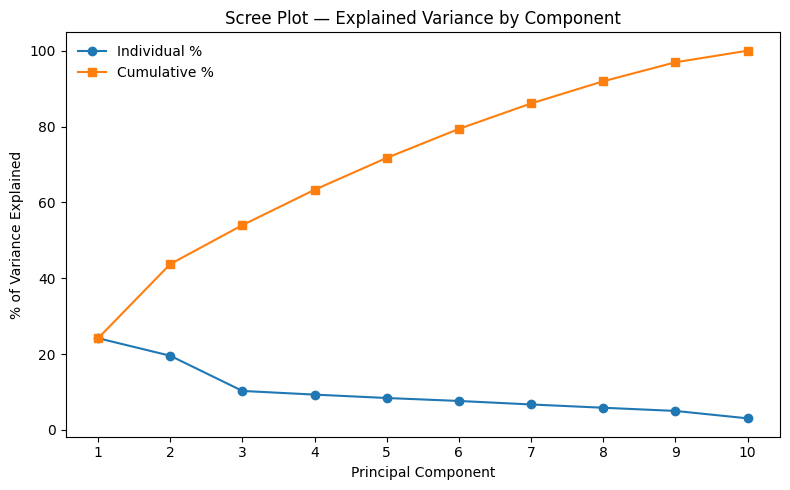

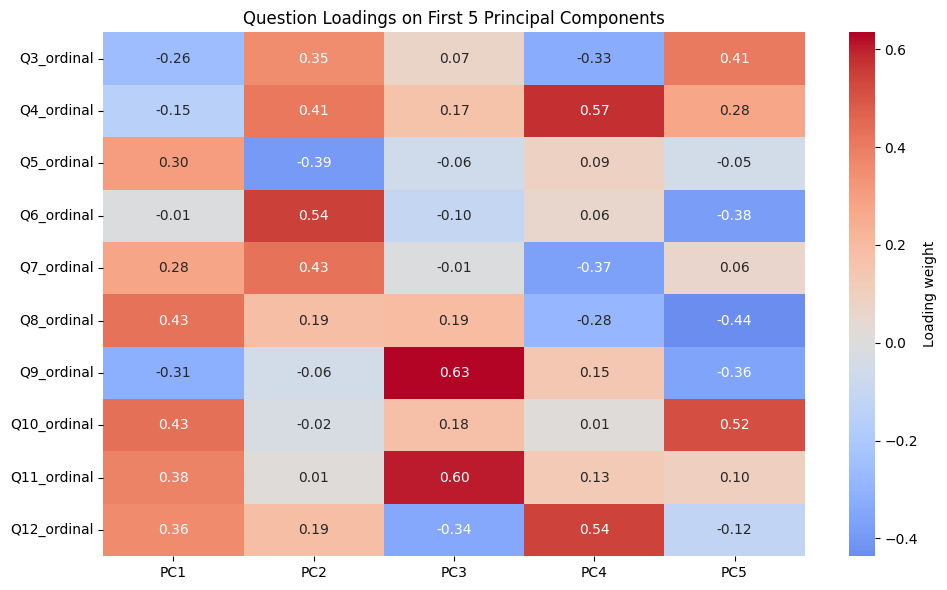

,Component,Top0,Top1,Top2
0,PC1,Q10_ordinal,Q8_ordinal,Q11_ordinal
1,PC2,Q6_ordinal,Q7_ordinal,Q4_ordinal
2,PC3,Q9_ordinal,Q11_ordinal,Q12_ordinal
3,PC4,Q4_ordinal,Q12_ordinal,Q7_ordinal
4,PC5,Q10_ordinal,Q8_ordinal,Q3_ordinal
5,PC6,Q7_ordinal,Q3_ordinal,Q10_ordinal
6,PC7,Q5_ordinal,Q4_ordinal,Q10_ordinal
7,PC8,Q3_ordinal,Q12_ordinal,Q9_ordinal
8,PC9,Q6_ordinal,Q5_ordinal,Q12_ordinal
9,PC10,Q7_ordinal,Q8_ordinal,Q10_ordinal


In [12]:
X  = df[bias_cols].values
Xz = StandardScaler().fit_transform(X)

pca        = PCA()
components = pca.fit_transform(Xz)

expl_var   = pca.explained_variance_ratio_
cum_var    = np.cumsum(expl_var)

#Scree
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(range(1,len(expl_var)+1), expl_var*100, marker='o', label='Individual %')
ax.plot(range(1,len(cum_var)+1),  cum_var*100,  marker='s', label='Cumulative %')
ax.set_title('Scree Plot — Explained Variance by Component')
ax.set_xlabel('Principal Component')
ax.set_ylabel('% of Variance Explained')
ax.set_xticks(range(1,len(expl_var)+1))
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

#Loadings heatmap
loadings = pd.DataFrame(pca.components_.T,
                        index=bias_cols,
                        columns=[f'PC{i+1}' for i in range(len(bias_cols))])

plt.figure(figsize=(10,6))
sns.heatmap(loadings.iloc[:,:5], annot=True, cmap='coolwarm', center=0,
            fmt='.2f', cbar_kws={'label':'Loading weight'})
plt.title('Question Loadings on First 5 Principal Components')
plt.tight_layout()
plt.show()

# Top drivers
abs_loadings = loadings.abs()
n_top        = 3

top_drivers = (abs_loadings
               .apply(lambda x: x.nlargest(n_top).index)
               .T
               .add_prefix('Top').rename_axis('Component')
               .reset_index())

display(top_drivers)
